## Time Series Prediction
This notebook will look into answering our research question using time series data as input.

**Research question** : Predicting student reflection responses to the "How do you feel about your learning progress" question from their session interactions (response time, response correctness) and from the characteristics of the session (number of questions, feedback mode, time of the day, etc.)

#### Useful imports and setup

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

%load_ext autoreload
%autoreload 2

DATA_DIR = '../data' # Change accordingly

In [2]:
# Run this cell if working on Colab
from google.colab import drive
drive.mount('/content/drive')
DATA_DIR = '/content/drive/MyDrive/Classtime'

Mounted at /content/drive


### Load data

In [3]:
# We decide to consider a fixed amount of time steps
N_STEPS = 10 # Note: can be tuned

X = np.load(f'{DATA_DIR}/processed/{N_STEPS}-steps.npy', allow_pickle=True)
labels = pd.read_csv(f'{DATA_DIR}/processed/participant-labels.csv.gz')

N_FEATURES = X.shape[2]

## Binary prediction models
We will first investigate predicting the feeling of learning as happy versus not happy (binary prediction).

In [4]:
# Import code written for task
from modules.models import binary

In [5]:
y = labels.response.map({'happy': 1.0, 'neutral': 0.0, 'upset': 0.0}).to_numpy() # Happy or not

In [6]:
# Number of participants == number of labels
X.shape[0] == y.shape[0]

True

### Split data

In [7]:
# Split data into train, val, and test
from sklearn.model_selection import train_test_split

# Split into train-val and test
X_train_val, X_test, y_train_val, y_test = train_test_split(X[:322651], y[:322651], test_size=0.1, random_state=123)

# Split train-val in their respective sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=123)

### Parameters

In [8]:
## MODEL PARAMETERS ## Can be tuned for optimization
params = {}
params['batch_size'] = 16
params['mask_value'] = -1.0
params['verbose'] = 1
params['weights_dir'] = f'{DATA_DIR}/weights'
params['optimizer'] = 'adam'
params['n_units'] = 32 # Number of recurrent units
params['epochs'] = 20
params['dropout'] = 0.1
params['patience'] = 3 # Early stopping patience

#### Baseline
We first run predictions on a simple neural network with a fully connected hidden layer to compare its performance to the recurrent neural networks.

In [9]:
# Define Baseline model
baseline = binary.fully_connected(N_FEATURES, N_STEPS, params)
baseline.summary()

Model: "Baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, None, 9)]         0         
                                                                 
 masking (Masking)           (None, None, 9)           0         
                                                                 
 reshape (Reshape)           (None, 90)                0         
                                                                 
 dense (Dense)               (None, 90)                8190      
                                                                 
 dense_1 (Dense)             (None, 1)                 91        
                                                                 
Total params: 8,281
Trainable params: 8,281
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Fit Baseline model on train and validation data
binary.fit_model(baseline, params, 'Baseline', X_train, y_train, X_val, y_val)

Epoch 1/20
7260/7260 [==============================] - 5s 658us/step - loss: 0.6457 - auc: 0.6646 - binary_accuracy: 0.6283 - val_loss: 0.6384 - val_auc: 0.6757 - val_binary_accuracy: 0.6368
Epoch 2/20
7260/7260 [==============================] - 4s 612us/step - loss: 0.6421 - auc: 0.6708 - binary_accuracy: 0.6327 - val_loss: 0.6367 - val_auc: 0.6782 - val_binary_accuracy: 0.6389
Epoch 3/20
7260/7260 [==============================] - 5s 669us/step - loss: 0.6410 - auc: 0.6724 - binary_accuracy: 0.6345 - val_loss: 0.6374 - val_auc: 0.6773 - val_binary_accuracy: 0.6376
Epoch 4/20
7260/7260 [==============================] - 5s 652us/step - loss: 0.6407 - auc: 0.6730 - binary_accuracy: 0.6347 - val_loss: 0.6371 - val_auc: 0.6779 - val_binary_accuracy: 0.6396
Epoch 5/20
7260/7260 [==============================] - 5s 727us/step - loss: 0.6402 - auc: 0.6741 - binary_accuracy: 0.6351 - val_loss: 0.6373 - val_auc: 0.6774 - val_binary_accuracy: 0.6389


### Recurrent Neural Networks
We now investigate the predicting performance of simple recurrent neural network architectures.

#### Recurrent neural network

In [11]:
# Define RNN model
rnn = binary.create_model(N_FEATURES, params, 'RNN')
rnn.summary()

Model: "BinaryRNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, None, 9)]         0         
                                                                 
 masking_1 (Masking)         (None, None, 9)           0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                1344      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,377
Trainable params: 1,377
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Fit RNN model on train and validation data
binary.fit_model(rnn, params, 'RNN', X_train, y_train, X_val, y_val)

Epoch 1/20
7260/7260 [==============================] - 11s 1ms/step - loss: 0.6530 - auc_1: 0.6485 - binary_accuracy: 0.6204 - val_loss: 0.6438 - val_auc_1: 0.6728 - val_binary_accuracy: 0.6324
Epoch 2/20
7260/7260 [==============================] - 11s 1ms/step - loss: 0.6511 - auc_1: 0.6525 - binary_accuracy: 0.6234 - val_loss: 0.6424 - val_auc_1: 0.6763 - val_binary_accuracy: 0.6325
Epoch 3/20
7260/7260 [==============================] - 12s 2ms/step - loss: 0.6506 - auc_1: 0.6534 - binary_accuracy: 0.6226 - val_loss: 0.6405 - val_auc_1: 0.6774 - val_binary_accuracy: 0.6356
Epoch 4/20
7260/7260 [==============================] - 11s 2ms/step - loss: 0.6501 - auc_1: 0.6546 - binary_accuracy: 0.6238 - val_loss: 0.6424 - val_auc_1: 0.6773 - val_binary_accuracy: 0.6302
Epoch 5/20
7260/7260 [==============================] - 11s 1ms/step - loss: 0.6499 - auc_1: 0.6551 - binary_accuracy: 0.6236 - val_loss: 0.6389 - val_auc_1: 0.6774 - val_binary_accuracy: 0.6390
Epoch 6/20
7260/7260 [===

#### LSTM

In [13]:
# Define LSTM model
lstm = binary.create_model(N_FEATURES, params, 'LSTM')
lstm.summary()

Model: "BinaryLSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, None, 9)]         0         
                                                                 
 masking_2 (Masking)         (None, None, 9)           0         
                                                                 
 lstm (LSTM)                 (None, 32)                5376      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5,409
Trainable params: 5,409
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Fit LSTM model on train and validation data
binary.fit_model(lstm, params, 'LSTM', X_train, y_train, X_val, y_val)

Epoch 1/20
7260/7260 [==============================] - 22s 3ms/step - loss: 0.6514 - auc_2: 0.6519 - binary_accuracy: 0.6216 - val_loss: 0.6420 - val_auc_2: 0.6746 - val_binary_accuracy: 0.6323
Epoch 2/20
7260/7260 [==============================] - 19s 3ms/step - loss: 0.6489 - auc_2: 0.6570 - binary_accuracy: 0.6261 - val_loss: 0.6388 - val_auc_2: 0.6785 - val_binary_accuracy: 0.6389
Epoch 3/20
7260/7260 [==============================] - 19s 3ms/step - loss: 0.6487 - auc_2: 0.6574 - binary_accuracy: 0.6249 - val_loss: 0.6411 - val_auc_2: 0.6781 - val_binary_accuracy: 0.6337
Epoch 4/20
7260/7260 [==============================] - 19s 3ms/step - loss: 0.6485 - auc_2: 0.6578 - binary_accuracy: 0.6253 - val_loss: 0.6382 - val_auc_2: 0.6795 - val_binary_accuracy: 0.6400
Epoch 5/20
7260/7260 [==============================] - 19s 3ms/step - loss: 0.6481 - auc_2: 0.6584 - binary_accuracy: 0.6256 - val_loss: 0.6375 - val_auc_2: 0.6805 - val_binary_accuracy: 0.6416
Epoch 6/20
7260/7260 [===

#### GRU

In [15]:
# Define GRU model
gru = binary.create_model(N_FEATURES, params, 'GRU')
gru.summary()

Model: "BinaryGRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, None, 9)]         0         
                                                                 
 masking_3 (Masking)         (None, None, 9)           0         
                                                                 
 gru (GRU)                   (None, 32)                4128      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,161
Trainable params: 4,161
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Fit GRU model on train and validation data
binary.fit_model(gru, params, 'GRU', X_train, y_train, X_val, y_val)

Epoch 1/20
7260/7260 [==============================] - 21s 3ms/step - loss: 0.6512 - auc_3: 0.6526 - binary_accuracy: 0.6226 - val_loss: 0.6405 - val_auc_3: 0.6784 - val_binary_accuracy: 0.6336
Epoch 2/20
7260/7260 [==============================] - 18s 2ms/step - loss: 0.6489 - auc_3: 0.6571 - binary_accuracy: 0.6248 - val_loss: 0.6389 - val_auc_3: 0.6799 - val_binary_accuracy: 0.6391
Epoch 3/20
7260/7260 [==============================] - 19s 3ms/step - loss: 0.6490 - auc_3: 0.6566 - binary_accuracy: 0.6244 - val_loss: 0.6401 - val_auc_3: 0.6787 - val_binary_accuracy: 0.6347
Epoch 4/20
7260/7260 [==============================] - 18s 2ms/step - loss: 0.6485 - auc_3: 0.6577 - binary_accuracy: 0.6253 - val_loss: 0.6403 - val_auc_3: 0.6788 - val_binary_accuracy: 0.6348
Epoch 5/20
7260/7260 [==============================] - 18s 3ms/step - loss: 0.6482 - auc_3: 0.6584 - binary_accuracy: 0.6254 - val_loss: 0.6376 - val_auc_3: 0.6798 - val_binary_accuracy: 0.6399
Epoch 6/20
7260/7260 [===

#### Model evaluation
We will now evaluate the binary prediction models on the testing data:

In [17]:
models = [(baseline, 'Baseline'), (rnn, 'RNN'), (lstm, 'LSTM'), (gru, 'GRU')]
results = []
for mod, mod_name in models:
    acc, auc = binary.evaluate_model(mod, params, mod_name, X_test, y_test)
    results.append((mod_name, acc, auc))
results = pd.DataFrame(results, columns=['Model', 'Accuracy', 'AUC'])

Model: Baseline
Balanced accuracy: 0.6162
AUC: 0.6728
Model: RNN
Balanced accuracy: 0.6116
AUC: 0.6684
Model: LSTM
Balanced accuracy: 0.6149
AUC: 0.6739
Model: GRU
Balanced accuracy: 0.6162
AUC: 0.6740


In [18]:
display(results)

,Model,Accuracy,AUC
0,Baseline,0.616237,0.672756
1,RNN,0.611630,0.668389
2,LSTM,0.614939,0.673934
3,GRU,0.616241,0.674035


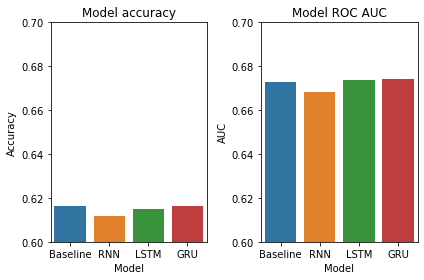

In [32]:
fig, axs = plt.subplots(1, 2)

sns.barplot(data=results, x='Model', y='Accuracy', ax=axs[0])
axs[0].set_title('Model accuracy')
axs[0].set_ylim(0.6, 0.7)
sns.barplot(data=results, x='Model', y='AUC', ax=axs[1])
axs[1].set_title('Model ROC AUC')
axs[1].set_ylim(0.6, 0.7)

fig.tight_layout()
plt.show()

A densely connected neural network seems to perform similarly as a recurrent neural network on this particular prediction task (**note the small range of the y-axis**). Aside from this, no other interesting comparison can be made between models unfortunately. 

### LSTM hyperparameter tuning
We will now investigate tuning the hyperparameters of the LSTM model such as the number of recurrent units and dropout rate.

In [21]:
# Grid search
aucs = []
for n_units in [8, 16, 32, 64, 128]:
    for d_rate in [0.1, 0.2, 0.5]:
        params['n_units'] = n_units
        params['dropout'] = d_rate
        model = binary.create_model(N_FEATURES, params, recurrent_layer='LSTM')
        binary.fit_model(model, params, f'{n_units}-{d_rate}', X_train, y_train, X_val, y_val)
        _, auc = binary.evaluate_model(model, params, f'{n_units}-{d_rate}', X_test, y_test)
        aucs.append((n_units, d_rate, auc))

Epoch 1/20
7260/7260 [==============================] - 21s 3ms/step - loss: 0.6517 - auc_5: 0.6509 - binary_accuracy: 0.6212 - val_loss: 0.6401 - val_auc_5: 0.6779 - val_binary_accuracy: 0.6395
Epoch 2/20
7260/7260 [==============================] - 18s 2ms/step - loss: 0.6488 - auc_5: 0.6570 - binary_accuracy: 0.6264 - val_loss: 0.6386 - val_auc_5: 0.6795 - val_binary_accuracy: 0.6394
Epoch 3/20
7260/7260 [==============================] - 19s 3ms/step - loss: 0.6483 - auc_5: 0.6581 - binary_accuracy: 0.6258 - val_loss: 0.6383 - val_auc_5: 0.6800 - val_binary_accuracy: 0.6397
Epoch 4/20
7260/7260 [==============================] - 19s 3ms/step - loss: 0.6483 - auc_5: 0.6581 - binary_accuracy: 0.6257 - val_loss: 0.6380 - val_auc_5: 0.6803 - val_binary_accuracy: 0.6398
Epoch 5/20
7260/7260 [==============================] - 20s 3ms/step - loss: 0.6479 - auc_5: 0.6590 - binary_accuracy: 0.6260 - val_loss: 0.6382 - val_auc_5: 0.6804 - val_binary_accuracy: 0.6390
Epoch 6/20
7260/7260 [===

In [22]:
aucs = pd.DataFrame(aucs, columns=['units', 'dropout', 'AUC'])

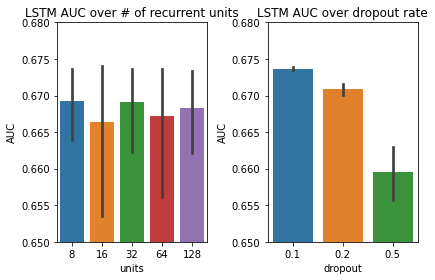

In [23]:
fig, axs = plt.subplots(1, 2)

sns.barplot(data=aucs, x='units', y='AUC', ax=axs[0])
axs[0].set_ylim(0.65, 0.68)
axs[0].set_title('LSTM AUC over # of recurrent units')

sns.barplot(data=aucs, x='dropout', y='AUC', ax=axs[1])
axs[1].set_ylim(0.65, 0.68)
axs[1].set_title('LSTM AUC over dropout rate')

fig.tight_layout()
plt.show()

In [24]:
print('Best parameters:')
aucs.sort_values(by='AUC', ascending=False).iloc[0][['units', 'dropout']]

Best parameters:


units      16.0
dropout     0.1
Name: 3, dtype: float64